## 特徴量作成

In [257]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from config import *

### データ読み込み

In [258]:
train = pd.read_csv(f"{args.data}train.csv")
test = pd.read_csv(f"{args.data}test.csv")
print(train.shape, test.shape)

(850, 11) (350, 10)


In [259]:
# あとから識別するためのカラム作成 --
train["train_test"] = "train"
test["train_test"] = "test"

train["index"] = train.index
test["index"] = test.index

In [260]:
df = pd.concat([train, test])
df

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,train_test,index
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0.0,train,0
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1.0,train,1
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0.0,train,2
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1.0,train,3
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0.0,train,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,65,Female,0.913867,0.120555,214.354728,16.964820,28.723677,6.960649,3.505619,1.224655,NaN,test,345
346,59,Male,0.818573,0.206075,215.898729,14.733461,20.470517,7.531071,3.637508,1.282833,NaN,test,346
347,25,Male,0.787054,0.186129,214.167523,14.936585,20.589993,7.505128,3.619033,1.287256,NaN,test,347
348,64,Male,0.725194,0.191307,220.272862,17.532595,48.115014,7.559414,3.635871,1.263348,NaN,test,348


### まず、hexbinの挙動を確認する

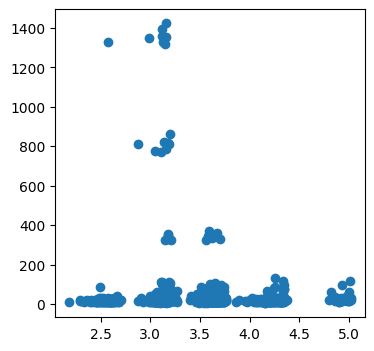

In [261]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.scatter(x=df["Alb"], y=df["ALT_GPT"])

In [262]:
df["Glb"] = df["Alb"] / df["AG_ratio"]

In [263]:
df.head(2)

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,train_test,index,Glb
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0.0,train,0,3.091250
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1.0,train,1,4.061404


### Albが明らかに群分けてそうなので, Albでグループ化 --

In [264]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=42).fit(df.loc[:, ["Alb", "Glb"]])
kmeans

KMeans(n_clusters=5, random_state=42)

In [265]:
df["Alb_Glb_kmeans"] = kmeans.labels_

<AxesSubplot: xlabel='Alb', ylabel='Glb'>

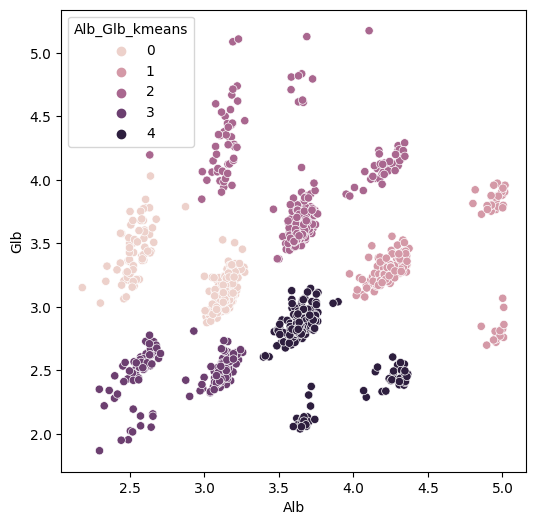

In [266]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

sns.scatterplot(x="Alb", y="Glb", data=df, hue=df["Alb_Glb_kmeans"])

### Alb_Glbのグループでagg

In [267]:
features = [col for col in df.columns if col not in ["Age", "Gender", "train_test", "index", "Alb_Glb_kmeans", "disease"]]

In [268]:
alb_glb_agg = df.groupby("Alb_Glb_kmeans")[features].agg(["mean", "std", "sum", "max", "min"]).reset_index()

In [269]:
alb_glb_agg_df = []
for col in features:
    tmp = alb_glb_agg[col]
    tmp.columns = [col+"_AlbGlb_"+c for c in alb_glb_agg[col]]
    alb_glb_agg_df.append(tmp)
alb_glb_agg_df = pd.concat(alb_glb_agg_df, axis=1).reset_index(drop=False, names="Alb_Glb_kmeans")

In [270]:
df = pd.merge(df, alb_glb_agg_df, how="left", on="Alb_Glb_kmeans")

In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 1199
Data columns (total 60 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Age                   1200 non-null   int64  
 1   Gender                1200 non-null   object 
 2   T_Bil                 1200 non-null   float64
 3   D_Bil                 1200 non-null   float64
 4   ALP                   1200 non-null   float64
 5   ALT_GPT               1200 non-null   float64
 6   AST_GOT               1200 non-null   float64
 7   TP                    1200 non-null   float64
 8   Alb                   1200 non-null   float64
 9   AG_ratio              1200 non-null   float64
 10  disease               850 non-null    float64
 11  train_test            1200 non-null   object 
 12  index                 1200 non-null   int64  
 13  Glb                   1200 non-null   float64
 14  Alb_Glb_kmeans        1200 non-null   int32  
 15  T_Bil_AlbGlb_mean    

### Genderでagg

In [272]:
tdf = df.iloc[:, :14].copy()
tdf

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,train_test,index,Glb
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0.0,train,0,3.091250
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1.0,train,1,4.061404
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0.0,train,2,3.212029
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1.0,train,3,3.657157
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0.0,train,4,2.989026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,65,Female,0.913867,0.120555,214.354728,16.964820,28.723677,6.960649,3.505619,1.224655,NaN,test,345,2.862536
1196,59,Male,0.818573,0.206075,215.898729,14.733461,20.470517,7.531071,3.637508,1.282833,NaN,test,346,2.835527
1197,25,Male,0.787054,0.186129,214.167523,14.936585,20.589993,7.505128,3.619033,1.287256,NaN,test,347,2.811434
1198,64,Male,0.725194,0.191307,220.272862,17.532595,48.115014,7.559414,3.635871,1.263348,NaN,test,348,2.877965


In [273]:
gen_agg_df = tdf.groupby("Gender")[features].agg(["mean", "std", "sum", "max", "min"])
gen_agg_df.columns = ["_Gender_".join(x) for x in gen_agg_df.columns]
gen_agg_df = gen_agg_df.reset_index(drop=False)

In [274]:
df = pd.merge(df, gen_agg_df, how="left", on="Gender")

In [275]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 1199
Data columns (total 105 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    Age                   1200 non-null   int64  
 1    Gender                1200 non-null   object 
 2    T_Bil                 1200 non-null   float64
 3    D_Bil                 1200 non-null   float64
 4    ALP                   1200 non-null   float64
 5    ALT_GPT               1200 non-null   float64
 6    AST_GOT               1200 non-null   float64
 7    TP                    1200 non-null   float64
 8    Alb                   1200 non-null   float64
 9    AG_ratio              1200 non-null   float64
 10   disease               850 non-null    float64
 11   train_test            1200 non-null   object 
 12   index                 1200 non-null   int64  
 13   Glb                   1200 non-null   float64
 14   Alb_Glb_kmeans        1200 non-null   int32  
 15   T_

## Ageの年代でagg

In [276]:
df["Age_digit2"] = df["Age"].map(lambda x: int(np.floor(x/10)*10))

In [277]:
tdf = df.iloc[:, :14].copy()
tdf

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,train_test,index,Glb
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0.0,train,0,3.091250
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1.0,train,1,4.061404
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0.0,train,2,3.212029
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1.0,train,3,3.657157
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0.0,train,4,2.989026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,65,Female,0.913867,0.120555,214.354728,16.964820,28.723677,6.960649,3.505619,1.224655,NaN,test,345,2.862536
1196,59,Male,0.818573,0.206075,215.898729,14.733461,20.470517,7.531071,3.637508,1.282833,NaN,test,346,2.835527
1197,25,Male,0.787054,0.186129,214.167523,14.936585,20.589993,7.505128,3.619033,1.287256,NaN,test,347,2.811434
1198,64,Male,0.725194,0.191307,220.272862,17.532595,48.115014,7.559414,3.635871,1.263348,NaN,test,348,2.877965


In [278]:
tdf["Age_digit2"] = tdf["Age"].map(lambda x: int(np.floor(x/10)*10))

In [279]:
age_agg_df = tdf.groupby("Age_digit2")[features].agg(["mean", "std", "sum", "max", "min"])
age_agg_df.columns = ["_Age_".join(x) for x in age_agg_df.columns]
age_agg_df = age_agg_df.reset_index(drop=False)

In [280]:
df = pd.merge(df, age_agg_df, how="left", on="Age_digit2")

In [281]:
df.info(max_cols=200)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 1199
Data columns (total 151 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    Age                   1200 non-null   int64  
 1    Gender                1200 non-null   object 
 2    T_Bil                 1200 non-null   float64
 3    D_Bil                 1200 non-null   float64
 4    ALP                   1200 non-null   float64
 5    ALT_GPT               1200 non-null   float64
 6    AST_GOT               1200 non-null   float64
 7    TP                    1200 non-null   float64
 8    Alb                   1200 non-null   float64
 9    AG_ratio              1200 non-null   float64
 10   disease               850 non-null    float64
 11   train_test            1200 non-null   object 
 12   index                 1200 non-null   int64  
 13   Glb                   1200 non-null   float64
 14   Alb_Glb_kmeans        1200 non-null   int32  
 15   T_

## 元のfeatureの四則演算系 -

In [282]:
tdf = df.iloc[:, :14].copy()
tdf

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,disease,train_test,index,Glb
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,0.0,train,0,3.091250
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,1.0,train,1,4.061404
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,0.0,train,2,3.212029
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,1.0,train,3,3.657157
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,0.0,train,4,2.989026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,65,Female,0.913867,0.120555,214.354728,16.964820,28.723677,6.960649,3.505619,1.224655,NaN,test,345,2.862536
1196,59,Male,0.818573,0.206075,215.898729,14.733461,20.470517,7.531071,3.637508,1.282833,NaN,test,346,2.835527
1197,25,Male,0.787054,0.186129,214.167523,14.936585,20.589993,7.505128,3.619033,1.287256,NaN,test,347,2.811434
1198,64,Male,0.725194,0.191307,220.272862,17.532595,48.115014,7.559414,3.635871,1.263348,NaN,test,348,2.877965


In [283]:
cols = [col for col in features if col not in ["AG_ratio"]]

In [284]:
for col in cols:
    tdf[col] = (tdf[col] - tdf[col].mean())/tdf[col].std()

In [285]:
import itertools
import warnings
warnings.simplefilter("ignore")
patterns = list(itertools.permutations(cols, 2))

take = ["add", "sub", "mul", "div"]

for pair in patterns:
    for act in take:
        c = pair[0]+"-"+pair[1]+"-"+act
        if act == "add":
            tdf[c] = (tdf[pair[0]] + tdf[pair[1]])

        elif act == "sub":
            tdf[c] = (tdf[pair[0]] - tdf[pair[1]])
        
        elif act == "mul":
            tdf[c] = (tdf[pair[0]] * tdf[pair[1]])
        
        elif act == "div":
            tdf[c] = (tdf[pair[0]] / tdf[pair[1]])

In [286]:
tdf

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,...,Glb-AST_GOT-mul,Glb-AST_GOT-div,Glb-TP-add,Glb-TP-sub,Glb-TP-mul,Glb-TP-div,Glb-Alb-add,Glb-Alb-sub,Glb-Alb-mul,Glb-Alb-div
0,59,Male,-0.322037,-0.273961,-0.273963,-0.196318,-0.353758,-0.273801,-0.727962,1.006802,...,0.034460,0.275358,-0.371211,0.176390,0.026671,0.355771,-0.825373,0.630552,0.070911,0.133812
1,69,Male,-0.237558,-0.246141,-0.268779,0.090569,0.032112,-0.187065,-0.833756,0.751346,...,0.055466,53.787724,1.540186,1.914317,-0.323109,-9.233419,0.893495,2.561008,-1.440107,-2.071650
2,65,Male,-0.372524,-0.316627,0.227501,-0.202753,-0.274079,-1.292842,-1.812995,0.774952,...,-0.035562,-0.473407,-1.163091,1.422593,-0.167747,-0.100361,-1.683244,1.942746,-0.235238,-0.071567
3,65,Male,-0.275367,-0.234707,0.469318,-0.036860,-0.059749,-0.095988,0.145418,0.988155,...,-0.057774,-16.183339,0.870958,1.062934,-0.092815,-10.073637,1.112363,0.821528,0.140611,6.649444
4,22,Female,0.046878,-0.244859,-0.260985,-0.142056,0.976162,-1.422258,-0.803847,1.026654,...,-0.282768,-0.296747,-1.711931,1.132585,0.411990,0.203671,-1.093520,0.514174,0.232853,0.360359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,65,Female,-0.272626,-0.292420,-0.302996,-0.169610,-0.291026,-0.103658,-0.043024,1.224655,...,0.153538,1.812812,-0.631233,-0.423917,0.054688,5.089562,-0.570599,-0.484551,0.022698,12.262371
1196,59,Male,-0.309707,-0.239699,-0.295299,-0.186651,-0.365048,0.566050,0.186638,1.282833,...,0.211134,1.584377,-0.012323,-1.144424,-0.327388,-1.021770,-0.391735,-0.765011,-0.107946,-3.098908
1197,25,Male,-0.321971,-0.251996,-0.303929,-0.185100,-0.363976,0.535592,0.154467,1.287256,...,0.227008,1.713542,-0.088097,-1.159280,-0.334042,-1.164485,-0.469222,-0.778155,-0.096339,-4.037685
1198,64,Male,-0.346043,-0.248803,-0.273493,-0.165274,-0.117106,0.599327,0.183786,1.263348,...,0.058384,4.257287,0.100772,-1.097882,-0.298798,-0.831859,-0.314769,-0.682342,-0.091628,-2.712690


In [287]:
df = pd.merge(df, tdf, how="left", on=["train_test", "index"], suffixes=("", "_normal"))

In [288]:
df

,Age,Gender,T_Bil,D_Bil,ALP,ALT_GPT,AST_GOT,TP,Alb,AG_ratio,...,Glb-AST_GOT-mul,Glb-AST_GOT-div,Glb-TP-add,Glb-TP-sub,Glb-TP-mul,Glb-TP-div,Glb-Alb-add,Glb-Alb-sub,Glb-Alb-mul,Glb-Alb-div
0,59,Male,0.786886,0.150498,220.178691,13.467617,21.729246,6.815731,3.112276,1.006802,...,0.034460,0.275358,-0.371211,0.176390,0.026671,0.355771,-0.825373,0.630552,0.070911,0.133812
1,69,Male,1.003987,0.195625,221.218413,51.033462,64.752323,6.889608,3.051521,0.751346,...,0.055466,53.787724,1.540186,1.914317,-0.323109,-9.233419,0.893495,2.561008,-1.440107,-2.071650
2,65,Male,0.657140,0.081287,320.770533,12.625011,30.613180,5.947767,2.489167,0.774952,...,-0.035562,-0.473407,-1.163091,1.422593,-0.167747,-0.100361,-1.683244,1.942746,-0.235238,-0.071567
3,65,Male,0.906822,0.214173,369.278160,34.347597,54.510085,6.967183,3.613837,0.988155,...,-0.057774,-16.183339,0.870958,1.062934,-0.092815,-10.073637,1.112363,0.821528,0.140611,6.649444
4,22,Female,1.734959,0.197706,222.782025,20.572891,170.010177,5.837537,3.068697,1.026654,...,-0.282768,-0.296747,-1.711931,1.132585,0.411990,0.203671,-1.093520,0.514174,0.232853,0.360359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,65,Female,0.913867,0.120555,214.354728,16.964820,28.723677,6.960649,3.505619,1.224655,...,0.153538,1.812812,-0.631233,-0.423917,0.054688,5.089562,-0.570599,-0.484551,0.022698,12.262371
1196,59,Male,0.818573,0.206075,215.898729,14.733461,20.470517,7.531071,3.637508,1.282833,...,0.211134,1.584377,-0.012323,-1.144424,-0.327388,-1.021770,-0.391735,-0.765011,-0.107946,-3.098908
1197,25,Male,0.787054,0.186129,214.167523,14.936585,20.589993,7.505128,3.619033,1.287256,...,0.227008,1.713542,-0.088097,-1.159280,-0.334042,-1.164485,-0.469222,-0.778155,-0.096339,-4.037685
1198,64,Male,0.725194,0.191307,220.272862,17.532595,48.115014,7.559414,3.635871,1.263348,...,0.058384,4.257287,0.100772,-1.097882,-0.298798,-0.831859,-0.314769,-0.682342,-0.091628,-2.712690


## このへんで一旦保存

In [290]:
df.to_feather("./input/df_feature01.feather")